In [1]:
import src.data as data
import src.models as models
import src.train as train
import src.dataset as dataset

import logging
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random

logging.basicConfig(level=logging.INFO)

DATA_LINK = "https://andrewjanowczyk.com/wp-static/epi.tgz"
BASE_DIR = os.path.abspath('')
IMAGE_DIR = os.path.join(BASE_DIR, "data")
MASK_DIR = os.path.join(IMAGE_DIR, "masks")
TRAIN_IMAGE_DIR = os.path.join(IMAGE_DIR, "train/images")
TRAIN_MASK_DIR = os.path.join(IMAGE_DIR, "train/masks")
TEST_DIR = os.path.join(IMAGE_DIR, "test")
HDF5_FILE_PATH = os.path.join(IMAGE_DIR, "train_data.h5")
CHECKPOINT_PATH = os.path.join(BASE_DIR, "model_checkpoint.pth")

logging.debug("base directory: %s", BASE_DIR)
logging.debug("image directory: %s", IMAGE_DIR)
logging.debug("mask directory: %s", MASK_DIR)
logging.debug("train image directory: %s", TRAIN_IMAGE_DIR)
logging.debug("train mask directory: %s", TRAIN_MASK_DIR)
logging.debug("test directory: %s", TEST_DIR)
logging.debug("hdf5 file path: %s", HDF5_FILE_PATH)
logging.debug("checkpoint path: %s", CHECKPOINT_PATH)

def main(mode = 'train'):
    logging.info("mode: %s", mode)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.info("device: %s", device)

    logging.info("preparing datasets...")
    data.prepare_datasets(DATA_LINK, IMAGE_DIR, MASK_DIR, TRAIN_IMAGE_DIR, TRAIN_MASK_DIR, TEST_DIR)
    data.create_h5_files(HDF5_FILE_PATH, TRAIN_IMAGE_DIR, TRAIN_MASK_DIR)

    logging.info("loading dataset...")
    ds = dataset.SegmentationDataset(HDF5_FILE_PATH)
    data_loader = DataLoader(ds, batch_size=4, shuffle=True)

    logging.info("setting up the model...")
    model = models.UNet(n_channels=3, n_classes=1)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    if mode == 'train':
        logging.info("training the model...")
        train.train_model(model, data_loader, 10, optimizer, criterion, device, CHECKPOINT_PATH)
        logging.info("model trained.")
    elif mode == 'eval':
        logging.info("evaluating the model...")
        train.load_checkpoint(model, optimizer, CHECKPOINT_PATH, device)

        for idx in random.sample(range(len(ds)), 5):
            logging.info("evaluating image %d...", idx)
            image, mask = ds[idx]
            pred = train.evaluate_model(model, image, device)
            ds.plot_with_pred(image, mask, pred)
    else:
        logging.error("invalid mode: %s", mode)


INFO:root:mode: eval
INFO:root:device: cpu
INFO:root:preparing datasets...
INFO:root:creating directories...
INFO:root:directories created.
INFO:root:sorting images and masks...
INFO:root:images and masks sorted.
INFO:root:loading dataset...
INFO:root:setting up the model...
INFO:root:evaluating the model...
INFO:root:evaluating image 3...


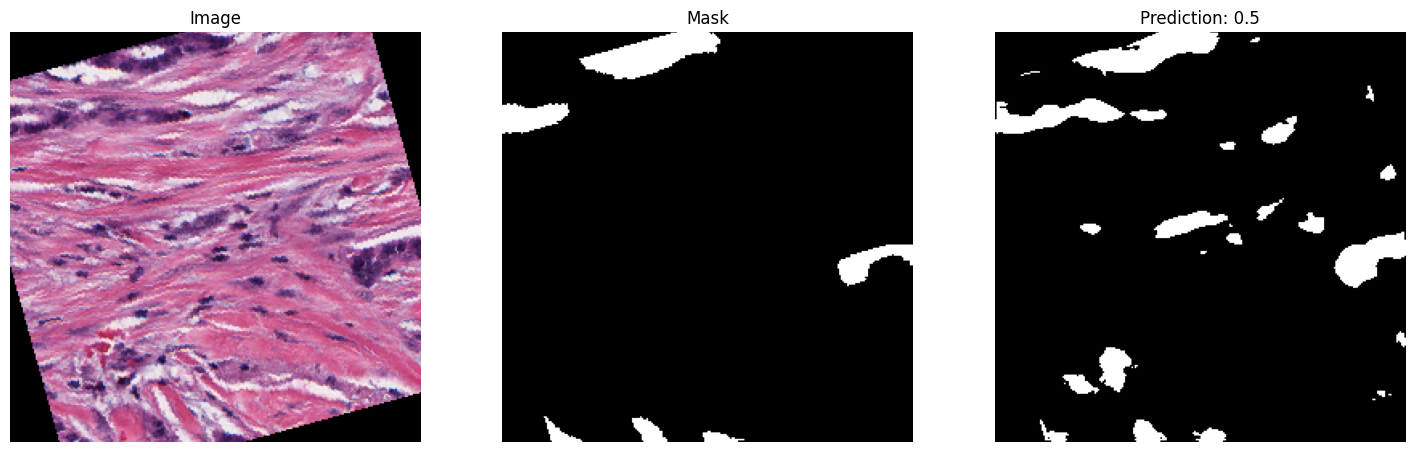

INFO:root:evaluating image 4...


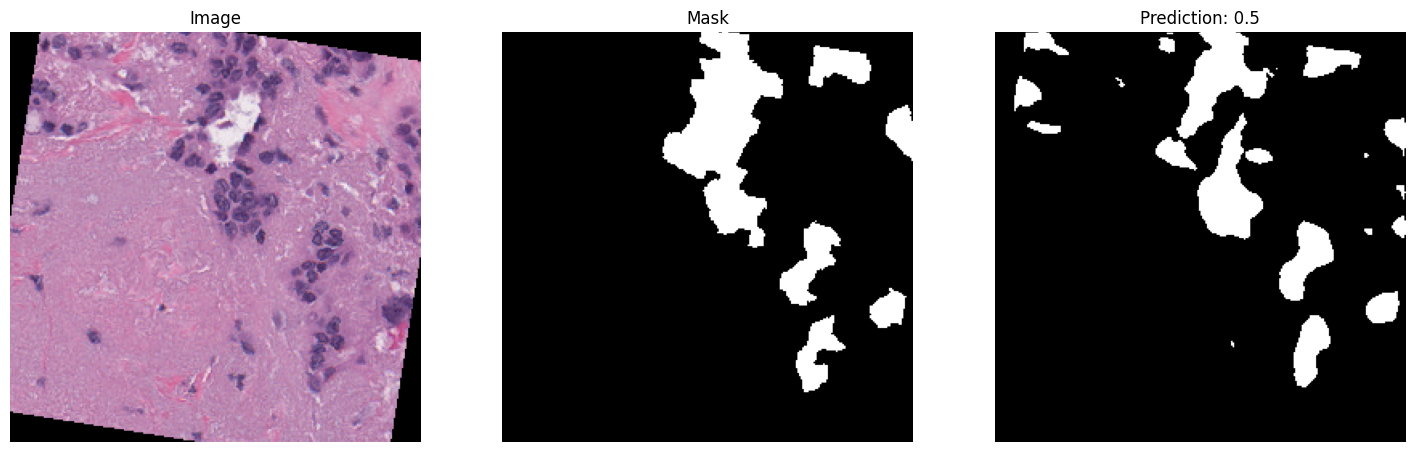

INFO:root:evaluating image 10...


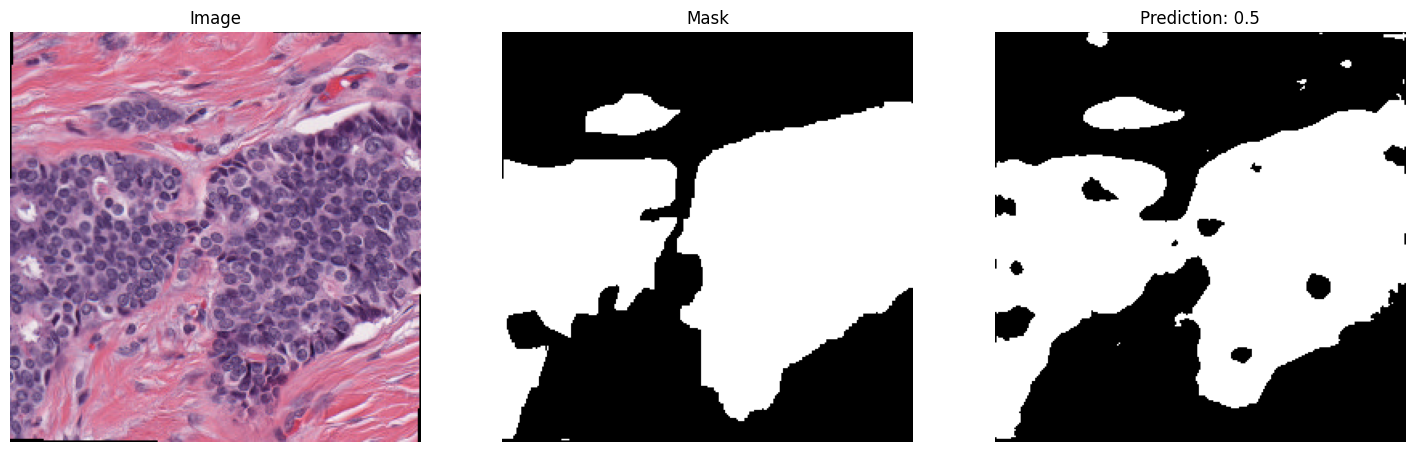

INFO:root:evaluating image 14...


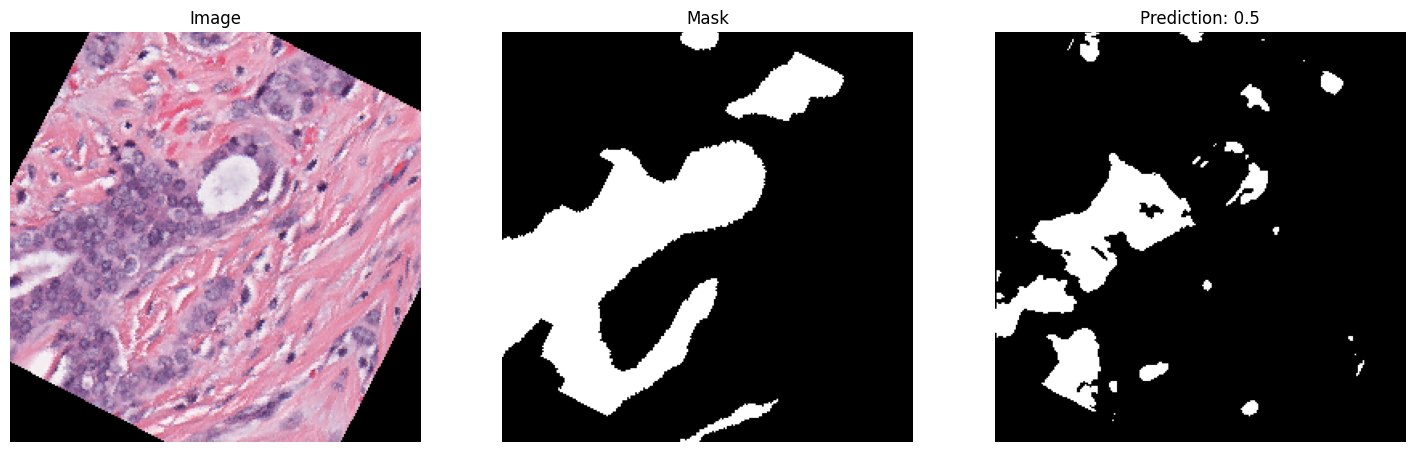

INFO:root:evaluating image 1...


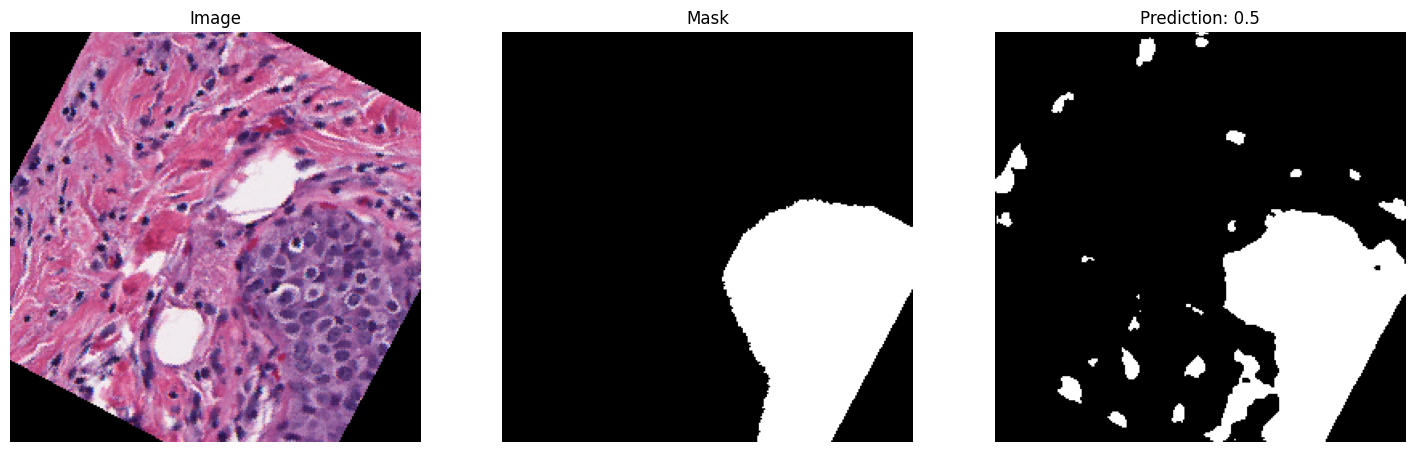

In [2]:
main("eval")